In [1]:
#CUDA_VISIBLE_DEVICES=""
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

When u run in colab, make colab flag True.

In [2]:
colab=False #True/False: #When u run in colab, make this flag True.

In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
if colab:
    #Add a shortcut of project folder to your drive's home for this to work
    !ls '/content/drive/MyDrive/Traffic'
    root = '/content/drive/MyDrive/Traffic'
else:
    import os
    root = os.getcwd()
root

'/home/skycam/sample_projs/FRCNN/delivered/FastRCNN_Pytorch'

In [5]:
#!unzip "/content/drive/MyDrive/Traffic/Traffic_FRCNN.zip" -d "/content/drive/MyDrive/Traffic/"

Uncomment above line after putting zip file inside Traffic folder. Create another notebook and put above cells in it do this unzipping

In [6]:
if colab:
    import sys
    sys.path.append(root)

In [7]:
if colab:
    !pip3 install -r '/content/drive/MyDrive/Traffic/requirements.txt'
else:
    !pip3 install -r requirements.txt

  Using cached keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl


  Attempting uninstall: keras-retinanet
    Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [8]:
import os
from utilities.data_utils.Dataset import DatasetGen, get_transform
from utilities.utils import collate_fn
from utilities.train_eval.engine import train_one_epoch, evaluate, get_model_result
import glob

import nvidia_smi # for python 3, you need nvidia-ml-py3 library

import torch
torch.cuda.empty_cache()
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead

Select project name suitably (student may delete this cell by pressing d twice)

In [9]:
PATH = 'Weight.pth'

output_image_folder = 'output'

proj = 'sign' # 'sign','fabric' (put ur project name here)

if proj == 'sign':
    classes = ['warning', 'prohibitory', 'mandatory']
elif proj == 'fabric':
    classes = ['Hole', 'Line', 'Stain']
else:
    classes = ['bg']

num_classes = len(classes)+1  # n class + background

batch_size = 3

num_epochs = 5

In [10]:
torch.cuda.empty_cache()
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 8505131008
Free memory: 8173584384
Used memory: 331546624


In [11]:
dataset_train = DatasetGen(root+'/data/train', get_transform(horizontal_flip=True),classes=classes)
dataset_test = DatasetGen(root+'/data/test', get_transform(horizontal_flip=False),classes=classes)

data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=collate_fn)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device

device(type='cuda')

In [13]:
anchor_generator = AnchorGenerator(sizes=((32,), (24, ), (24, ), (16,), (8, )),
                                        aspect_ratios=([1.0, 1.0, 1.0, 1.0], 
                                                     [0.8, 1.0, 1.0, 1.0], 
                                                     [1.0, 0.8, 1.0, 1.0],
                                                     [1.0, 1.0, 1.0, 1.0],
                                                     [1.0, 1.0, 1.0, 1.0]))

In [14]:
model.rpn.anchor_generator = anchor_generator
model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [15]:
if os.path.isfile(PATH):
    model.load_state_dict(torch.load(PATH))

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Training
Change 'if 0:' to 'if 1:' for training

In [16]:
if 0:#make this 1 for training to happen
    for epoch in range(num_epochs):
        res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
        print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1)
        lr_scheduler.step()
        evaluate(model, data_loader_test, device=device)

    print("Training complete!")
    
    torch.cuda.synchronize()
    # create directory for saving the model
    print("Saving model...")
    torch.save(model.state_dict(), PATH)
    print("Model saving complete!")
    nvidia_smi.nvmlShutdown()

In [17]:
# create output directory
# if output directory exists, delete existing files
if not os.path.exists(output_image_folder):
    os.mkdir(output_image_folder)
else:
    files = glob.glob(output_image_folder + '/*')
    for f in files:
        os.remove(f)

## Evaluate

In [18]:
evaluate(model, data_loader_test, device=device)

n_threads =  4
creating index...
index created!
Test:  [0/3]  eta: 0:00:03  model_time: 1.0934 (1.0934)  evaluator_time: 0.0201 (0.0201)  time: 1.1591  data: 0.0434  max mem: 523
Test:  [2/3]  eta: 0:00:00  model_time: 0.1239 (0.4405)  evaluator_time: 0.0008 (0.0071)  time: 0.4955  data: 0.0459  max mem: 588
Test: Total time: 0:00:01 (0.5086 s / it)
Averaged stats: model_time: 0.1239 (0.4405)  evaluator_time: 0.0008 (0.0071)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (A

## Inference 
Repeating all the process to ensure nothing is taken from training stage
Check output folder for results

In [124]:
import numpy as np
from torchvision import transforms
model.eval()
from PIL import Image, ImageDraw

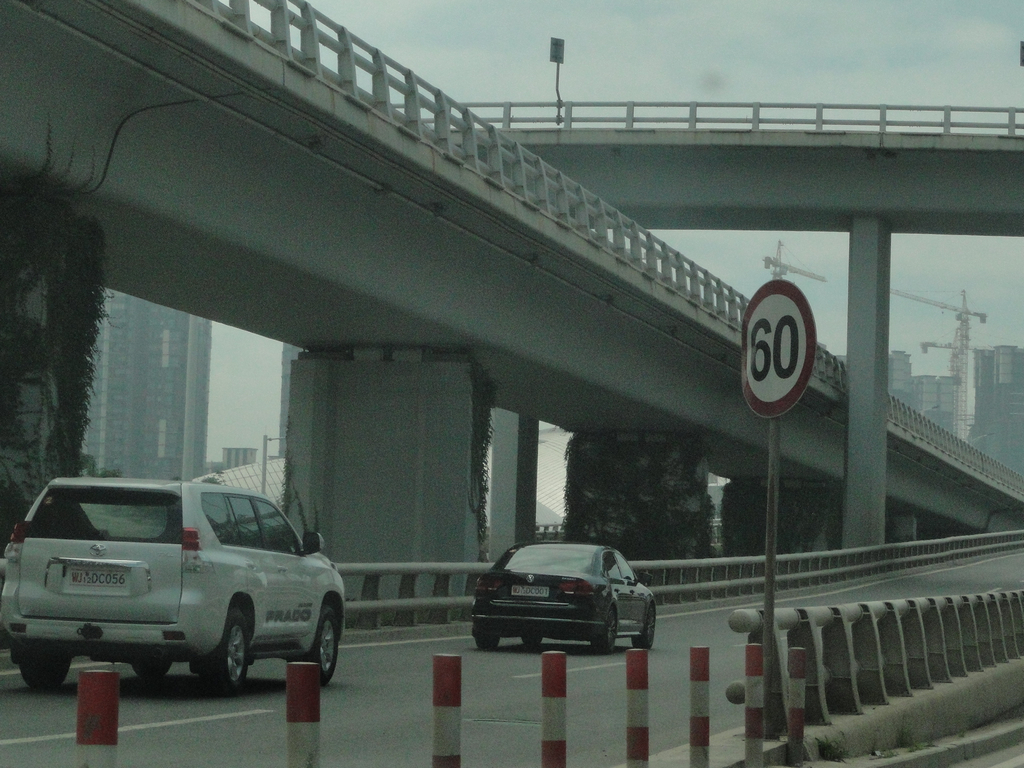

In [125]:
img_path = 'data/test/images/00001.png'
img = Image.open(img_path).convert("RGB")
img

In [126]:
pil_to_tensor = transforms.ToTensor()(img)#.unsqueeze_(0)
print(pil_to_tensor.shape) 

torch.Size([3, 768, 1024])


In [127]:
prediction = model([pil_to_tensor.to(device)])
prediction = prediction[0]
prediction

{'boxes': tensor([[698.4111, 282.2277, 885.4802, 439.1678],
         [680.2311, 262.8489, 891.4729, 461.2425],
         [705.8500, 286.6283, 865.1495, 431.6470]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([1, 3, 2], device='cuda:0'),
 'scores': tensor([0.3921, 0.3849, 0.2087], device='cuda:0', grad_fn=<IndexBackward>)}

In [128]:

boxes, scores, labels = prediction["boxes"], prediction["scores"], prediction["labels"]
labels1 = labels.detach().cpu().numpy()
text_labels = []


for i in labels:
    if i>0:
        cls  = classes[i-1]
        text_labels.append(cls)
print('initial boxes:',text_labels)

initial boxes: ['warning', 'mandatory', 'prohibitory']


In [129]:
n_s = scores.cpu().detach().numpy()
print(n_s)
threshold = 0.45
ind = np.where(n_s>threshold)
ind = ind[0]
# In case no boxes are above threshold
if len(ind)==0:
    ind=[0]

# Applying NMS
boxes = boxes[ind]
n_s = n_s[ind]
iou_threshold=0.45
ind = torchvision.ops.nms(boxes.cpu(), torch.from_numpy(n_s), iou_threshold)
print(ind)

[0.3920998  0.3848677  0.20870753]
tensor([0])


In [130]:
for j in ind:
        box = boxes[j]
        box = box.tolist()
        cls = text_labels[j]
        
        print('Final pred boxes:', cls, box)
        draw = ImageDraw.Draw(img)
        draw.text((box[0], box[1]-10), cls, fill=(60,60,255))
        draw.rectangle(box, outline = "blue")
        del draw
        

Final pred boxes: warning [698.4111328125, 282.22772216796875, 885.4801635742188, 439.16778564453125]


In [131]:
img.show(command='fim')
filename = os.path.split(img_path)[1]
img.save(os.path.join('output' ,filename))

## Classifier modules

In [ ]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

In [21]:
from utilities.classifier import Classifier

GPU found


In [22]:
level1_obj = Classifier(exprmnt = 'level1',classes=['mandatory', 'prohibitory', 'warning'])
man_obj = Classifier(exprmnt = 'mandatory',classes=['cyclists_must_use_mandatory_path', 'other'])
war_obj = Classifier(exprmnt = 'warning',classes=['other', 'warning_for_children_and_minors'])
pro_obj = Classifier(exprmnt = 'prohibitory',classes=['other', 'speedlimit60'])

In [23]:
torch.cuda.empty_cache()
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

dataset_test = DatasetGen(root+'/data/test', get_transform(horizontal_flip=False),classes=classes)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

anchor_generator = AnchorGenerator(sizes=((32,), (24, ), (24, ), (16,), (8, )),
                                   aspect_ratios=([1.0, 1.0, 1.0, 1.0],
                                                  [0.8, 1.0, 1.0, 1.0],
                                                  [1.0, 0.8, 1.0, 1.0],
                                                  [1.0, 1.0, 1.0, 1.0],
                                                  [1.0, 1.0, 1.0, 1.0]))
model.rpn.anchor_generator = anchor_generator
model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(PATH))
model.to(device)

# create output directory
# if output directory exists, delete existing files
if not os.path.exists(output_image_folder):
    os.mkdir(output_image_folder)
else:
    files = glob.glob(output_image_folder + '/*')
    for f in files:
        os.remove(f)
# write testing result to output folder
for img_idx, batch_sampler in enumerate(data_loader_test):
    img_test = batch_sampler[0][0]
    target_test = batch_sampler[1][0]
    i = target_test["image_id"].item()
    print('\nimage id',i)
    #import pdb;pdb.set_trace()
    get_model_result(img_test, model, target_test, i, device, location=output_image_folder, threshold=0.2,classes=classes,level1=level1_obj,man=man_obj,war=war_obj,pro=pro_obj)

print("Testing complete!")

torch.cuda.synchronize()
nvidia_smi.nvmlShutdown()

Total memory: 8505131008
Free memory: 7442989056
Used memory: 1062141952

image id 0
initial boxes: ['warning', 'mandatory', 'prohibitory']
Final pred boxes: warning [698.4111328125, 282.22772216796875, 885.4801635742188, 439.16778564453125]
tf.Tensor([[1.1441439e-05 9.9998796e-01 5.6774076e-07]], shape=(1, 3), dtype=float32)
prohibitory
tf.Tensor([[0.01041247 0.98958755]], shape=(1, 2), dtype=float32)
speedlimit60

image id 1
initial boxes: ['mandatory', 'warning', 'mandatory', 'warning', 'prohibitory', 'mandatory', 'warning', 'prohibitory', 'prohibitory', 'mandatory', 'prohibitory']
Final pred boxes: mandatory [1151.7557373046875, 110.57440948486328, 1225.782958984375, 174.7506561279297]
tf.Tensor([[1.3698082e-11 3.7736803e-11 1.0000000e+00]], shape=(1, 3), dtype=float32)
warning
tf.Tensor([[8.826013e-06 9.999912e-01]], shape=(1, 2), dtype=float32)
warning_for_children_and_minors
Final pred boxes: mandatory [1168.392822265625, 131.7520751953125, 1216.6466064453125, 171.8172149658203]

Check output folder to see the result images